# Modelos de Machine Learning 

In [169]:
# hacer learning curves

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import joblib

## Importamos el Dataset

In [2]:
df_lem = pd.read_csv('../../cyberbullying/data/data_lem.csv')
df_lem.head()

,text,target
0,one make analogy mathematical terms envisionin...,0
1,clarification zundarks right checked wikipedia...,0
2,elected electoral jhk,0
3,fun entry devotchka coworker korea couldnt tel...,0
4,please relate ozone hole increases cancer prov...,0


In [168]:
'asd'.join(df_lem[df_lem['target']==1]['text'])

'wasted bit sexuality havent read diatribe one thing absolute certain never history planet umberto ever referred humbert kind lunacy renders wikipedia fringe place idiots play get seriousdwasderik crying loud legally sex children underage children underage children children beneath legal age consent different states underage limit children countries means someone age ireland example child aged age consent britain know first thing topic name standard english asage scandal pov term allegation allows discussion cases yet come court technical reasons prosecuted cases thrown invalid roman catholic church sex abuses allegations standard english means allegations roman catholic church public relations minor tabloid point discussing rape children stop adding irrelevant topic mucking around lost lot changes spelling corrections problems solved caught edit conflict given scale changes could nothing cut paste job tried go version transfer accurate changes started insane fucking around articles lo

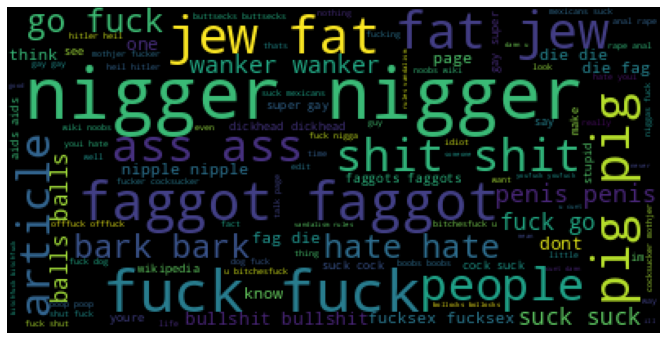

In [164]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_words=100).generate('asd'.join(df_lem[df_lem['target']==1]['text'][:10000]))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [165]:
wordcloud.words_

{'nigger nigger': 1.0,
 'fuck fuck': 0.6281721221037146,
 'faggot faggot': 0.5369621184258919,
 'pig pig': 0.4586244942993748,
 'jew fat': 0.45310776020595805,
 'fat jew': 0.45053328429569695,
 'shit shit': 0.42037513791835235,
 'ass ass': 0.41338727473335785,
 'people': 0.3990437660904744,
 'article': 0.3692534019860243,
 'bark bark': 0.36667892607576313,
 'hate hate': 0.35159985288709084,
 'go fuck': 0.3464509010665686,
 'penis penis': 0.34534755424788527,
 'wanker wanker': 0.34534755424788527,
 'suck suck': 0.3177638837808018,
 'fuck go': 0.3074659801397573,
 'balls balls': 0.3059948510481795,
 'bullshit bullshit': 0.3045237219566017,
 'one': 0.3001103346818683,
 'dont': 0.2828245678558293,
 'nipple nipple': 0.2802500919455682,
 'page': 0.26958440603162925,
 'know': 0.2607576314821626,
 'think': 0.23758734828981243,
 'die die': 0.23464509010665685,
 'fag die': 0.2294961382861346,
 'fucksex fucksex': 0.22912835601324016,
 'die fag': 0.22912835601324016,
 'faggots faggots': 0.22876057

In [158]:
len(wordcloud.words_)

100

In [3]:
df_lem.shape

(157203, 2)

## Distribución

In [4]:
def plot_dist(df):
    plt.figure(figsize = (7,7))
    sorted_counts = df['target'].value_counts()
    plt.pie(sorted_counts, labels = ['not bullying', 'bullying'], startangle = 90, counterclock = False,
            wedgeprops = {'width' : 0.6}, autopct='%1.1f%%', pctdistance = 0.7,
            textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
            colors = sns.color_palette("Paired")[7:])
    plt.text(x = -0.35, y = 0, s = f'Total comments: {df.shape[0]}')
    plt.title('Distribution of Comments in the Dataset', fontsize = 16);

In [5]:
percentage_used = 1
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

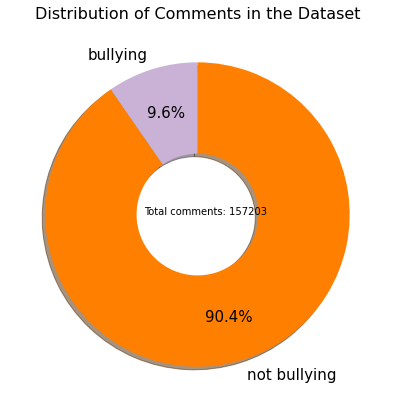

In [6]:
plot_dist(df_sample)

## Holdout

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['target'], test_size=0.3, random_state=0)

In [8]:
def balance_df(X, y, ratio=0.3):
    df = pd.DataFrame({'text': X, 'target': y})
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    df_class_1_len = df_class_1.shape[0]
    
    df_class_0_new = df_class_0.sample(int(df_class_1_len * (1-ratio)/ratio))
    df_new = pd.concat([df_class_0_new, df_class_1]).sample(frac=1).reset_index(drop=True)
    
    X = df_new['text']
    y = df_new['target']

    return X, y

#X_train, y_train = balance_df(X_train, y_train, ratio=0.1)
# no lo usamos

In [9]:
# Instantiate the CountVectorizer method
#count_vector = CountVectorizer(min_df=5)
count_vector = TfidfVectorizer(min_df=7)

# Fit the training data and then return the matrix
X_train_vec = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
X_test_vec = count_vector.transform(X_test)

In [11]:
training_data = X_train_vec
testing_data = X_test_vec

In [104]:
def pipeline(vectorizer_list, learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    def list_params(new_class):
        name = new_class.__class__.__name__
        default_class = eval(name + '()').get_params()
        new_class = new_class.get_params()

        new_dict = {}

        for key in new_class.keys():
            if new_class[key] != default_class[key]:
                new_dict[key] = new_class[key]
        return new_dict
    
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for vectorizer in vectorizer_list:
    
        for learner in learner_list:

            # Store the vectorizer name and params:
            results['Vectorizer'] = vectorizer.__class__.__name__
            results['Vectorizer Params'] = list_params(vectorizer)

            # Store the learner name and params:
            results['Algorithm'] = learner.__class__.__name__
            results['Algorithm Params'] = list_params(learner)

            # Fit the learner:
            start = time() # Get start time
            #print("Training {}".format(learner.__class__.__name__))
            learner = learner.fit(X_train, y_train)
            end = time() # Get end time

            # Store the training time
            results['Training Time'] = round(end - start, 2)

            start = time() # Get start time
            predictions_test = learner.predict(X_test)
            predictions_train = learner.predict(X_train)
            end = time() # Get end time

            # Store the prediction time
            results['Prediction Time'] = round(end - start, 2)

            # Compute the F1 Score on Test Set
            results['f1'] = round(f1_score(y_test, predictions_test), 4)

            # Compute the F1 Score on Training Set
            #results['F1 Score: Train'] = round(f1_score(y_train, predictions_train), 4)

            # Compute the Recall on Test Set
            results['recall'] = round(recall_score(y_test, predictions_test), 4)

            # Compute the Recall on Training Set
            #results['Recall: Train'] = round(recall_score(y_train, predictions_train), 4)
            
            # Compute the Precision on Test Set
            results['precision'] = round(precision_score(y_test, predictions_test), 4)

            # Compute the Precision on Training Set
            #results['Precision: Train'] = round(precision_score(y_train, predictions_train), 4)
            
            # Compute the Accuracy on Test Set
            results['accuracy'] = round(accuracy_score(y_test, predictions_test), 4)

            # Compute the Accuracy on Training Set
            #results['Accuracy: Train'] = round(accuracy_score(y_train, predictions_train), 4)

            # Success
            #print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
            #print('----------------------------------------------------')

            final_results.append(results.copy())
            
    # Return a dataframe of the results
    return final_results

In [105]:
#vectorizer = TfidfVectorizer(min_df=5)
#model = LinearSVC(C=1.1)

In [106]:
import itertools

In [108]:
%%time
# make a list of vectorizers
vectorizers = [TfidfVectorizer(min_df=5)]

C = 1

class_weight = {0:0.22, 1:0.78}
class_weight_list = [{0: round(weight_0, 2), 1: 1-round(weight_0,2)} for weight_0 in np.arange(0.17, 0.24, 0.01)]

# make a list of models
models = [LinearSVC(C=C, class_weight=class_weight) for class_weight in class_weight_list]

re = pipeline(vectorizers, models, X_train_vec, y_train, X_test_vec, y_test)
results = pd.DataFrame(re)

results = results.sort_values(by = 'f1', ascending = False).reset_index(drop = True)

results

CPU times: user 4.7 s, sys: 24.1 ms, total: 4.73 s
Wall time: 4.73 s


,Vectorizer,Vectorizer Params,Algorithm,Algorithm Params,Training Time,Prediction Time,f1,recall,precision,accuracy
0,TfidfVectorizer,{'min_df': 5},LinearSVC,"{'class_weight': {0: 0.22, 1: 0.78}}",0.60,0.01,0.7702,0.7751,0.7654,0.9562
1,TfidfVectorizer,{'min_df': 5},LinearSVC,"{'class_weight': {0: 0.23, 1: 0.77}}",0.60,0.01,0.7700,0.7700,0.7700,0.9564
2,TfidfVectorizer,{'min_df': 5},LinearSVC,"{'class_weight': {0: 0.21, 1: 0.79}}",0.61,0.01,0.7671,0.7789,0.7556,0.9552
3,TfidfVectorizer,{'min_df': 5},LinearSVC,"{'class_weight': {0: 0.2, 1: 0.8}}",0.62,0.01,0.7653,0.7827,0.7486,0.9545
4,TfidfVectorizer,{'min_df': 5},LinearSVC,"{'class_weight': {0: 0.19, 1: 0.81}}",0.64,0.01,0.7622,0.7863,0.7395,0.9535
5,TfidfVectorizer,{'min_df': 5},LinearSVC,"{'class_weight': {0: 0.18, 1: 0.82000000000000...",0.71,0.01,0.7599,0.7908,0.7314,0.9527
6,TfidfVectorizer,{'min_df': 5},LinearSVC,"{'class_weight': {0: 0.17, 1: 0.83}}",0.67,0.01,0.7585,0.7973,0.7233,0.9519


In [127]:
results['accuracy']

0    0.9562
1    0.9564
2    0.9552
3    0.9545
4    0.9535
5    0.9527
6    0.9519
Name: accuracy, dtype: float64

In [141]:
[dic['class_weight'][0] for dic in results['Algorithm Params'].values]

[0.22, 0.23, 0.21, 0.2, 0.19, 0.18, 0.17]

In [148]:
results['f1']

0    0.7702
1    0.7700
2    0.7671
3    0.7653
4    0.7622
5    0.7599
6    0.7585
Name: f1, dtype: float64

In [146]:
def plot_scores(results):
    score_results = {'class_weight': [dic['class_weight'][0] for dic in results['Algorithm Params'].values],
                     'accuracy': results['accuracy'],
                     'precision': results['precision'],
                     'recall': results['recall'],
                     'f1': results['f1'],
                     'time': results['Training Time'] + results['Prediction Time']}        
        
    plt.figure(figsize=(12,6))
        
    #plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    #plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    #return score_results

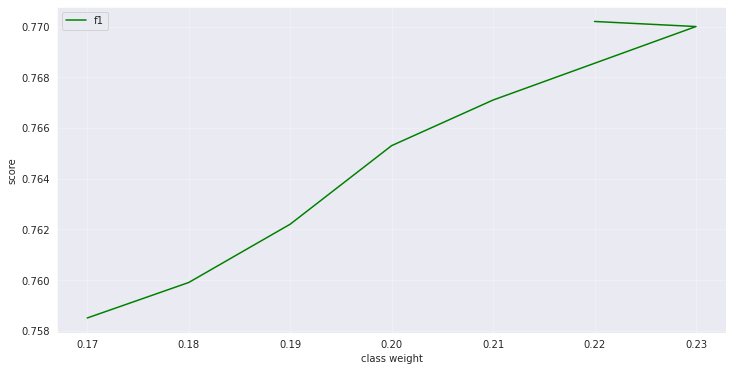

In [147]:
plot_scores(results)

In [75]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn import set_config; set_config(display='diagram')

from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

In [76]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)

In [77]:
pipe = make_pipeline(
    preprocessing,
    model
)

pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(min_df=5))]),
                                                  'text')])),
                ('linearsvc', LinearSVC(class_weight={0: 0.22, 1: 0.78}))])

In [78]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('tfidfvectorizer',
                                                     TfidfVectorizer(min_df=5))]),
                                    'text')])),
  ('linearsvc', LinearSVC(class_weight={0: 0.22, 1: 0.78}))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('tfidfvectorizer',
                                                   TfidfVectorizer(min_df=5))]),
                                  'text')]),
 'linearsvc': LinearSVC(class_weight={0: 0.22, 1: 0.78}),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('pipeline',
   Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(min_df=5))]),
   'tex

In [79]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scorer = make_scorer(f1_score)

In [80]:
def conf_mx_all(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1= np.round((2*precision*recall)/(precision+recall), 3)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {F1}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot();
    
    return recall, precision, accuracy, F1

In [81]:
X_train = pd.DataFrame(data=X_train, columns=['text'])
X_test = pd.DataFrame(data=X_test, columns=['text'])

In [82]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(5, 11),
    'linearsvc__C': np.arange(0.8, 1.3, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.17, 0.24, 0.01)]
    
}

In [83]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(8, 11),
    'linearsvc__C': np.arange(1, 1.2, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.19, 0.22, 0.01)],
    'linearsvc__dual': [False]
}

In [84]:
search = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring='f1')

In [85]:
%%time
search.fit(X_train, y_train)

CPU times: user 15.2 s, sys: 14.7 s, total: 29.9 s
Wall time: 1min 15s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('tfidfvectorizer',
                                                                                          TfidfVectorizer(min_df=5))]),
                                                                         'text')])),
                                       ('linearsvc',
                                        LinearSVC(class_weight={0: 0.22,
                                                                1: 0.78}))]),
             n_jobs=-1,
             param_grid={'columntransformer__pipeline__tfidfvectorizer__min_df': array([ 8,  9, 10]),
                         'linearsvc__C': array([1. , 1.1]),
                         'linearsvc__class_weight': [{0: 0.19, 1: 0.81},
                                                     {0: 0.2, 1: 0.8},
                                                     {0: 0.21000000000000002,
                                                      1: 0.79}],
                         'linearsvc__dual': [False]},
             scoring='f1')

In [26]:
search.best_params_

{'columntransformer__pipeline__tfidfvectorizer__min_df': 8,
 'linearsvc__C': 1.0,
 'linearsvc__class_weight': {0: 0.21000000000000002, 1: 0.79},
 'linearsvc__dual': False}

In [27]:
best_estimator = search.best_estimator_

In [28]:
y_pred = best_estimator.predict(X_test)

In [29]:
y_train.sum()

10689

In [30]:
y_train.mean()

0.09713563911960887

Recall: 0.778
Precision: 0.756
Accuracy: 0.955
F1-score: 0.767


(0.778, 0.756, 0.955, 0.767)

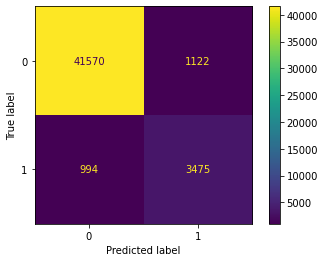

In [31]:
conf_mx_all(y_test, y_pred)

In [114]:
lista = ['you fucking retard', 'asshole', 'stupid bitch', 'hello!',
        "ns he can use and practice with. I can't say much more coz I don't have more space. Retard. This is all we need an Australian version of 1 Direction.... my dick was bleeding from how hard I was masturbating to this",
        ]
lista = pd.DataFrame(data=lista, columns=['text'])

best_estimator.predict(lista)

array([1, 1, 1, 0, 1])

In [102]:
def tune_threshold(C=1):
    score_results = {'class_weight': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    
    def scores2(cv_results, class_weight):
        score_results = {'class_weight': None, 'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
        for key in score_results.keys():
            if key == 'class_weight':
                score_results[key] = class_weight
            elif key == 'time':
                score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
            else:
                score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
        return score_results
    
    for class_weight in np.arange(0.05, 0.3, 0.05):
        print(class_weight)
        
        cv_results = cross_validate(LinearSVC(C=C, class_weight={0:class_weight, 1:1-class_weight}),
                                    X_train_vec, y_train, cv=5, n_jobs=-1,
                                    scoring=['accuracy', 'precision', 'recall', 'f1'])

        score_results_new = scores2(cv_results, class_weight)
        
        for key in score_results.keys():
            score_results[key].append(score_results_new[key])
            
        
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    return score_results

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.9101, 0.9392, 0.9488, 0.9534, 0.9553],
 'precision': [0.5218, 0.6447, 0.7109, 0.7545, 0.784],
 'recall': [0.8856, 0.8332, 0.7976, 0.7706, 0.7453],
 'f1': [0.6567, 0.7269, 0.7517, 0.7625, 0.7641],
 'time': [1.3, 1.2, 1.0, 0.8, 0.8]}

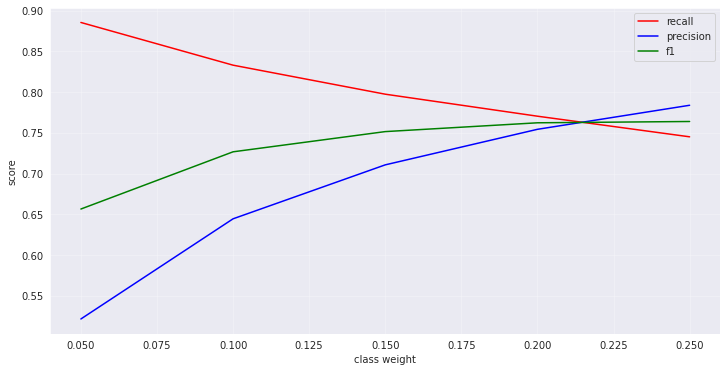

In [103]:
tune_threshold()

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.8843, 0.9379, 0.9508, 0.9555, 0.958],
 'precision': [0.4525, 0.6379, 0.7309, 0.7863, 0.8299],
 'recall': [0.9122, 0.834, 0.7816, 0.7443, 0.7141],
 'f1': [0.605, 0.7228, 0.7553, 0.7647, 0.7676],
 'time': [0.6, 0.6, 0.6, 0.5, 0.5]}

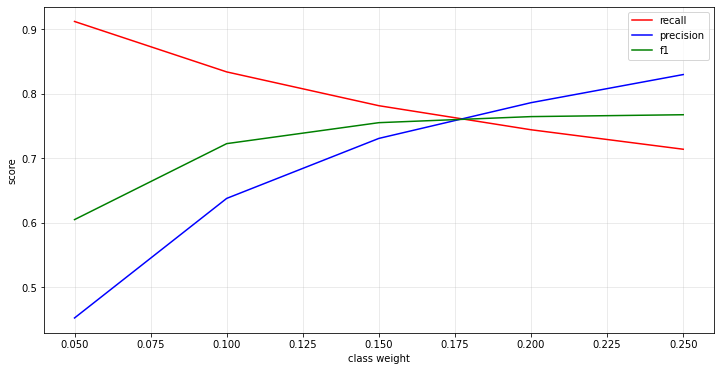

In [38]:
tune_threshold(C=0.25)

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.9001, 0.9388, 0.9502, 0.9544, 0.9573],
 'precision': [0.4922, 0.6422, 0.7211, 0.7675, 0.8071],
 'recall': [0.8995, 0.8369, 0.7948, 0.7606, 0.7361],
 'f1': [0.6362, 0.7267, 0.7562, 0.764, 0.7699],
 'time': [0.8, 0.8, 0.7, 0.6, 0.6]}

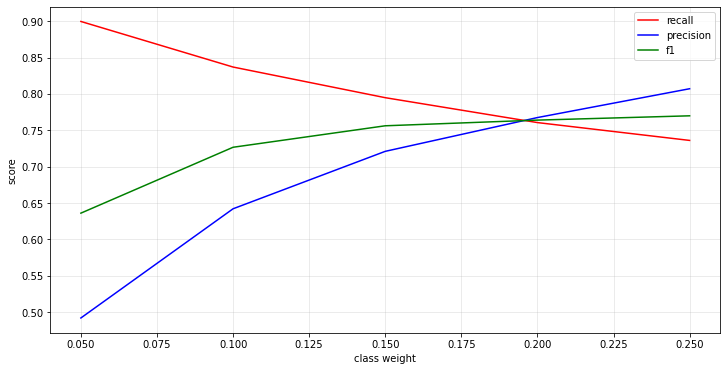

In [39]:
tune_threshold(C=0.5)

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.9065, 0.9391, 0.9494, 0.9537, 0.9562],
 'precision': [0.5107, 0.6438, 0.7149, 0.7592, 0.7931],
 'recall': [0.8915, 0.8353, 0.7976, 0.7672, 0.7433],
 'f1': [0.6494, 0.7271, 0.754, 0.7632, 0.7674],
 'time': [1.0, 0.9, 0.8, 0.8, 0.7]}

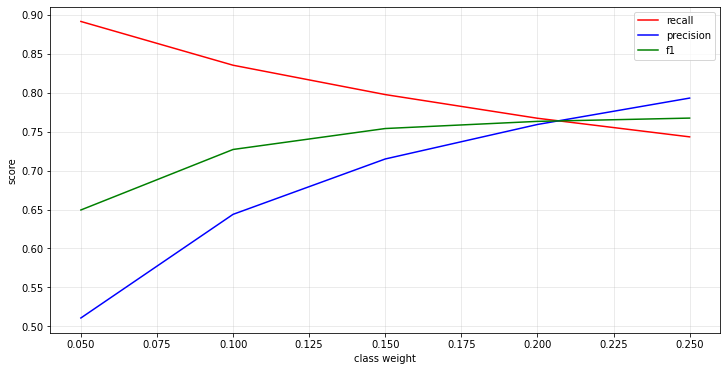

In [40]:
tune_threshold(C=0.75)

In [41]:
from sklearn.svm import SVC

In [42]:
class_weight = {0:0.22, 1:0.78}
model = LinearSVC(class_weight=class_weight)
#model = SVC(kernel='linear', class_weight=class_weight)

model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

In [43]:
y_pred.sum()

4526

In [44]:
y_test.sum()

4469

In [45]:
(y_test - y_pred).value_counts()

 0    45094
-1     1062
 1     1005
Name: target, dtype: int64

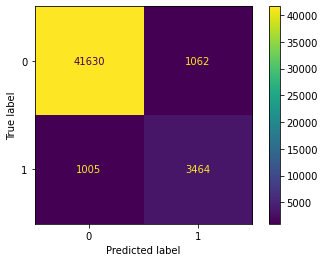

In [46]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot();

In [47]:
def conf_mx_metrics(cm):
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")

In [48]:
conf_mx_metrics(cm)

Recall: 0.775
Precision: 0.765
Accuracy: 0.956


In [49]:
def best_threshold(thresholds_list,model,x_test,y_test):
    recalls=[]
    accuracies=[]
    precisions=[]
    F1_scores=[]
    for threshold in thresholds:
        y_pred=threshold_modifier(model,x_test,threshold)
        cm = confusion_matrix(y_test, y_pred)
        recall, precision, accuracy,F1_score=conf_mx_metrics2(cm)
        recalls.append(recall)
        accuracies.append(accuracy)
        precisions.append(precision)
        F1_scores.append(F1_score)     

    metrics={'thresholds': thresholds,'recall':recalls, 'accuracy': accuracies, 'precision':precisions,'F1_score':F1_scores}
    return metrics

In [50]:
def threshold_modifier(model,xtest,threshold):
    ypred=model._predict_proba_lr(xtest)[:,1]>threshold
    ypred=ypred.astype(int)
    return ypred

In [51]:
model._predict_proba_lr(X_test_vec)

array([[0.37569962, 0.62430038],
       [0.78941859, 0.21058141],
       [0.89435927, 0.10564073],
       ...,
       [0.58412109, 0.41587891],
       [0.77031763, 0.22968237],
       [0.82710168, 0.17289832]])

In [52]:
def conf_mx_metrics2(cm):
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1=(2*precision*recall)/(precision+recall)
    
    return recall, precision, accuracy, F1

In [53]:
thresholds= np.arange(0.1, 0.9, 0.05)
thres = best_threshold(thresholds,model,X_test_vec,y_test)

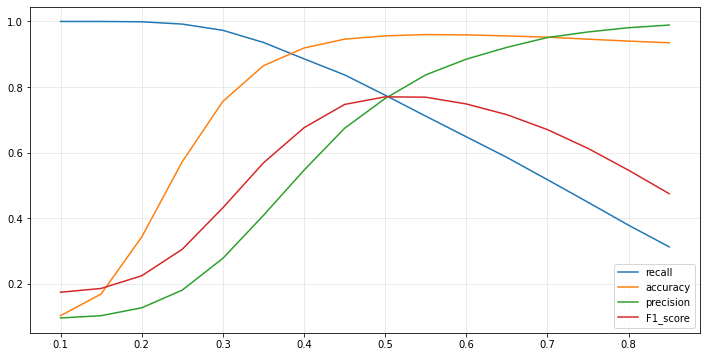

In [54]:
plt.figure(figsize=(12,6))
plt.plot(thresholds, thres['recall'], label='recall')
plt.plot(thresholds, thres['accuracy'], label='accuracy')
plt.plot(thresholds, thres['precision'], label='precision')
plt.plot(thresholds, thres['F1_score'], label='F1_score')
plt.grid(alpha=0.3)
plt.legend();

In [55]:
X_train_vec

<110042x22603 sparse matrix of type '<class 'numpy.float64'>'
	with 2805147 stored elements in Compressed Sparse Row format>

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.9101, 0.9392, 0.9488, 0.9534, 0.9553],
 'precision': [0.5218, 0.6447, 0.7109, 0.7545, 0.784],
 'recall': [0.8856, 0.8332, 0.7976, 0.7706, 0.7453],
 'f1': [0.6567, 0.7269, 0.7517, 0.7625, 0.7641],
 'time': [1.3, 1.2, 1.1, 0.9, 0.8]}

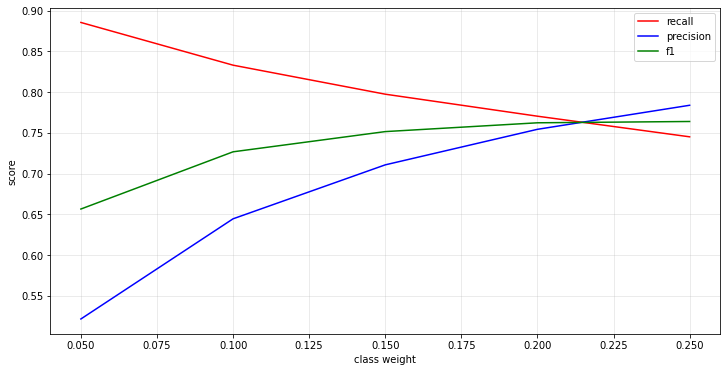

In [56]:
tune_threshold(C=1)

In [57]:
%%time
cv_results = cross_validate(LinearSVC(class_weight={0:.1, 1:.9}), X_train_vec, y_train, cv=5, n_jobs=-1,
                            scoring=['accuracy', 'precision', 'recall', 'f1'])

CPU times: user 44.6 ms, sys: 26.4 ms, total: 71 ms
Wall time: 1.23 s


In [58]:
def scores(cv_results):
    score_results = {'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
    for key in score_results.keys():
        if key == 'time':
            score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
        else:
            score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
    return score_results

In [59]:
scores(cv_results)

{'accuracy': 0.9392,
 'precision': 0.6447,
 'recall': 0.8332,
 'f1': 0.7269,
 'time': 1.0}

In [61]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

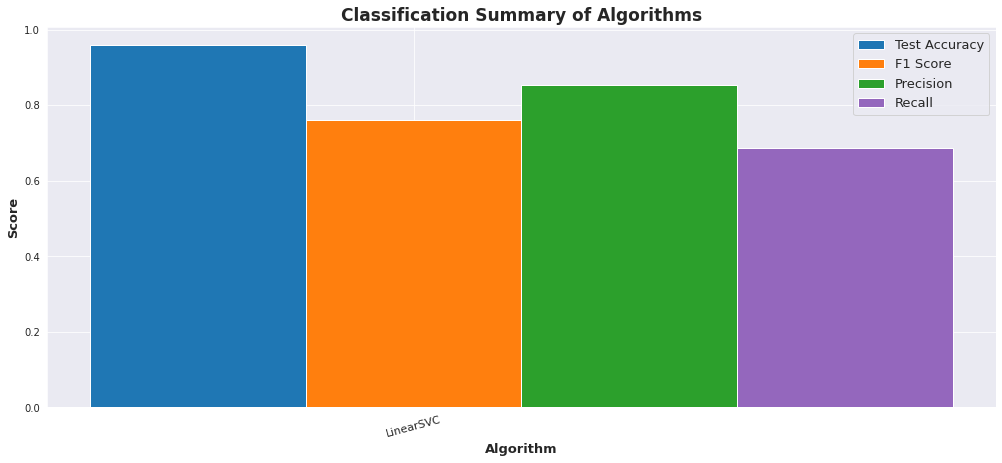

In [62]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
#plt.text(9.2, 1, textstr, fontsize=14,
#        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [63]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

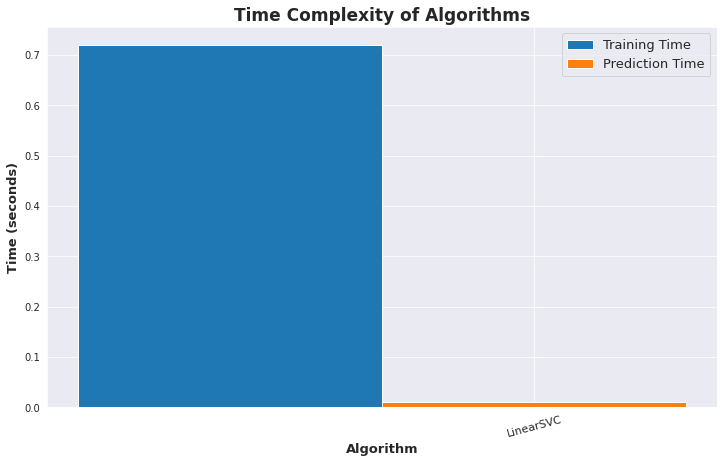

In [64]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
#plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

## Tunning Hyperparameters

In [65]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print(f"Best Parameters: {grid_fit.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, best_predictions):.4f}")
    print(f"F1-score: {f1_score(y_test, best_predictions):.4f}")
    print(f"Precision: {precision_score(y_test, best_predictions):.4f}")
    print(f"Recall: {recall_score(y_test, best_predictions):.4f}")
    
    return best_clf

In [66]:
%%time
# Linear SVC
param_grid = {
    'C': [0.25, 0.5, 0.75, 1]
}

clf_linsvc = LinearSVC(max_iter=10000, dual=True)

best_clf_linsvc = param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC

Optimized Model
------
Best Parameters: {'C': 1}
Accuracy: 0.9596
F1-score: 0.7632
Precision: 0.8589
Recall: 0.6867
CPU times: user 9.28 s, sys: 0 ns, total: 9.28 s
Wall time: 9.28 s


In [67]:
X_train_vec

<110042x22603 sparse matrix of type '<class 'numpy.float64'>'
	with 2805147 stored elements in Compressed Sparse Row format>

In [68]:
results_tunned = {'Model':[], 'Best Parameters':[], 'Accuracy':[], 'F1-score':[], 'Precision':[], 'Recall':[]}

for model in [best_clf_sgd, best_clf_linsvc]:
    best_predictions = model.predict(X_test_vec)
    results_tunned['Model'].append(model.__class__.__name__)
    results_tunned["Best Parameters"].append(model.get_params())
    results_tunned["Accuracy"].append(accuracy_score(y_test, best_predictions))
    results_tunned["F1-score"].append(f1_score(y_test, best_predictions))
    results_tunned["Precision"].append(precision_score(y_test, best_predictions))
    results_tunned["Recall"].append(recall_score(y_test, best_predictions))

#results_tunned
results_tunned = pd.DataFrame(results_tunned).sort_values(by = 'F1-score', ascending = False)
results_tunned

NameError: name 'best_clf_sgd' is not defined